# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 5,
        'beta': 1,
        'decision_sparsity': -1,
        'fully_grown': True,          
        'dt_type': 'SDT', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [0,1,2],
        
        'function_generation_type': 'random_decision_tree',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var10_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars-1_SDT_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var10_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars-1_SDT_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f7v9,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f8v9,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,f9v8,f9v9,...,f30v5,f30v6,f30v7,f30v8,f30v9,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,lp8c0,lp8c1,lp9c0,lp9c1,lp10c0,lp10c1,lp11c0,lp11c1,lp12c0,lp12c1,lp13c0,lp13c1,lp14c0,lp14c1,lp15c0,lp15c1,lp16c0,lp16c1,lp17c0,lp17c1,lp18c0,lp18c1,lp19c0,lp19c1,lp20c0,lp20c1,lp21c0,lp21c1,lp22c0,lp22c1,lp23c0,lp23c1,lp24c0,lp24c1,lp25c0,lp25c1,lp26c0,lp26c1,lp27c0,lp27c1,lp28c0,lp28c1,lp29c0,lp29c1,lp30c0,lp30c1,lp31c0,lp31c1
0,0.089,-0.275,0.315,-0.291,-0.095,0.101,-0.229,0.097,0.131,-0.014,0.265,0.029,-0.314,0.245,0.315,0.138,-0.232,0.235,0.124,-0.048,-0.039,-0.145,-0.071,0.069,0.301,-0.099,0.260,0.027,-0.194,-0.081,-0.126,0.070,-0.157,0.221,-0.314,0.293,0.090,-0.274,0.106,0.022,0.181,-0.068,-0.265,0.052,0.049,-0.007,-0.257,-0.022,-0.203,-0.225,-0.086,0.105,0.296,0.306,0.189,-0.186,0.225,0.006,0.118,0.169,-0.227,-0.296,0.255,-0.263,-0.195,-0.033,0.290,0.186,-0.177,0.303,-0.244,-0.244,0.185,-0.063,-0.170,-0.138,-0.263,0.284,-0.185,0.130,0.152,0.193,0.253,0.096,0.205,-0.184,-0.265,-0.060,0.142,-0.131,-0.007,0.260,-0.138,0.044,-0.003,-0.093,0.208,-0.251,0.272,-0.203,...,-0.258,0.270,-0.166,0.024,-0.311,-0.313,-0.150,-0.045,-0.132,-0.175,0.188,0.053,-0.244,0.111,0.115,-0.011,-0.180,0.203,0.254,-0.072,0.216,-0.070,0.314,0.058,0.211,-0.268,-0.237,-0.264,-0.001,0.281,-0.039,0.079,-0.059,-0.079,-0.002,-0.008,-0.129,-0.163,0.049,-0.130,0.075,-0.176,0.050,0.117,0.052,0.175,-0.074,-0.047,-0.073,0.029,-0.020,0.140,0.161,-0.110,0.094,0.013,-0.169,0.107,0.123,0.099,0.062,-0.033,0.121,-0.127,-0.083,-0.016,-0.014,-0.087,0.064,0.051,0.052,-0.032,-0.136,0.077,-0.135,-0.126,-0.072,-0.091,-0.083,-0.086,-0.140,0.155,0.040,0.051,0.087,0.032,0.163,-0.049,0.066,-0.017,0.048,0.124,0.100,0.107,0.154,0.019,-0.048,-0.039,0.137,0.135
1,0.102,0.076,0.206,-0.056,-0.128,-0.304,-0.300,0.213,-0.081,0.046,-0.056,-0.014,0.105,-0.017,0.010,0.163,0.068,-0.160,-0.250,-0.227,-0.067,0.184,0.105,0.272,0.142,-0.093,0.003,0.122,0.303,0.047,0.028,0.231,-0.050,-0.083,-0.175,0.167,-0.057,0.003,0.136,-0.104,0.277,0.030,0.219,0.288,0.291,-0.242,-0.065,0.058,0.250,-0.137,-0.156,-0.251,-0.253,0.231,-0.121,0.192,-0.270,-0.016,0.031,-0.230,-0.109,0.139,-0.241,0.244,-0.059,0.140,-0.053,-0.110,-0.111,-0.276,-0.307,0.119,-0.005,0.163,0.263,0.101,-0.300,-0.271,0.150,0.205,0.084,0.153,-0.268,-0.188,0.248,0.241,0.271,-0.230,0.042,0.297,-0.002,-0.265,0.255,-0.159,0.070,-0.010,-0.133,-0.077,-0.048,0.259,...,-0.197,-0.077,0.245,-0.173,0.191,-0.023,0.096,0.057,0.067,0.181,0.004,0.316,0.165,0.229,0.285,0.109,0.215,0.176,0.284,0.189,0.062,-0.140,0.062,0.176,-0.030,-0.100,-0.017,0.300,0.148,-0.273,-0.254,-0.132,-0.233,0.236,0.234,0.178,-0.094,0.107,0.028,0.095,-0.067,0.119,-0.146,0.138,-0.144,0.141,0.127,0.035,-0.151,-0.004,-0.055,-0.171,-0.154,0.035,-0.018,0.125,-0.128,0.065,-0.095,0.016,0.039,-0.077,0.043,0.087,0.019,-0.048,0.038,-0.132,0.011,-0.072,0.132,0.136,-0.074,-0.164,0.119,0.072,0.048,-0.044,0.061,0.173,-0.129,0.075,0.138,-0.019,0.087,-0.085,0.165,-0.124,0.142,0.072,0.152,0.166,0.069,-0.040,-0.001,-0.141,0.154,0.148,0.138,0.001
2,0.073,-0.075,0.087,-0.016,0.135,0.075,-0.036,-0.256,0.072,-0.280,0.042,0.021,-0.070,0.259,0.021,0.131,0.134,-0.187,-0.122,0.304,-0.310,-0.021,-0.025,0.224,-0.030,0.083,-0.015,-0.177,-0.179,-0.154,-0.287,-0.205,0.074,0.208,0.016,-0.145,0.139,-0.121,-0.070,-0.173,-0.099,-0.293,0.135,0.123,0.063,0.155,0.134,0.014,0.033,0.0

In [11]:
X_data_list[0][0].head(10)

f0v0    0.089
f0v1   -0.275
f0v2    0.315
f0v3   -0.291
f0v4   -0.095
f0v5    0.101
f0v6   -0.229
f0v7    0.097
f0v8    0.131
f0v9   -0.014
dtype: float32

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.000,1.000,1.000,0.545,0.424,0.646,0.438,0.892,0.964,0.383
1,1.000,1.000,1.000,0.926,0.071,0.087,0.020,0.833,0.778,0.870
2,1.000,1.000,0.000,0.781,0.118,0.640,0.143,0.945,0.522,0.415
3,0.000,1.000,0.000,0.568,0.019,0.618,0.612,0.617,0.944,0.682
4,0.000,0.000,1.000,0.060,0.667,0.671,0.210,0.129,0.315,0.364
5,1.000,0.000,1.000,0.102,0.209,0.161,0.653,0.253,0.466,0.244
6,0.000,0.000,1.000,0.138,0.197,0.369,0.821,0.097,0.838,0.096
7,1.000,0.000,1.000,0.605,0.739,0.039,0.283,0.120,0.296,0.119
8,0.000,0.000,0.000,0.692,0.567,0.265,0.523,0.094,0.576,0.929
9,0.000,1.000,0.000,0.716,0.289,0.183,0.587,0.020,0.829,0.005


In [13]:
y_data_list[0][0].head(10)

f0v0    0.089
f0v1   -0.275
f0v2    0.315
f0v3   -0.291
f0v4   -0.095
f0v5    0.101
f0v6   -0.229
f0v7    0.097
f0v8    0.131
f0v9   -0.014
dtype: float32

In [14]:
y_data_list[0][1].head(10)

,result
0,1.000
1,0.000
2,1.000
3,0.000
4,0.000
5,0.000
6,0.000
7,1.000
8,1.000
9,1.000


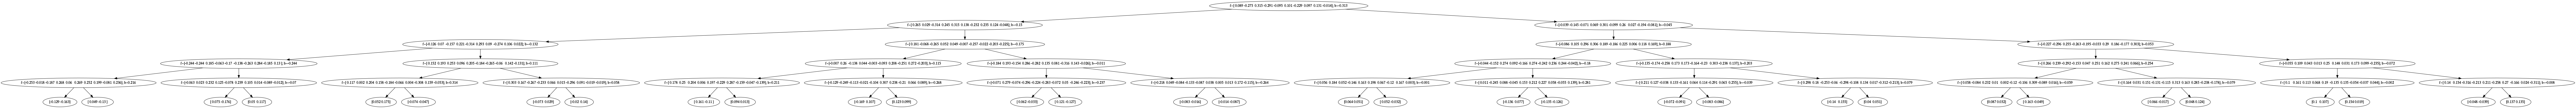

In [15]:
plot_tree_from_parameters(y_data_list[0][0].values, config)

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

f0v0    0.089
f0v1   -0.275
f0v2    0.315
f0v3   -0.291
f0v4   -0.095
f0v5    0.101
f0v6   -0.229
f0v7    0.097
f0v8    0.131
f0v9   -0.014
dtype: float32

In [19]:
y_data_list[0][0]

f0v0      0.089
f0v1     -0.275
f0v2      0.315
f0v3     -0.291
f0v4     -0.095
          ...  
lp29c1    0.019
lp30c0   -0.048
lp30c1   -0.039
lp31c0    0.137
lp31c1    0.135
Length: 405, dtype: float32

In [20]:
y_data_list[0][1].head(10)

,result
0,1.000
1,0.000
2,1.000
3,0.000
4,0.000
5,0.000
6,0.000
7,1.000
8,1.000
9,1.000


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

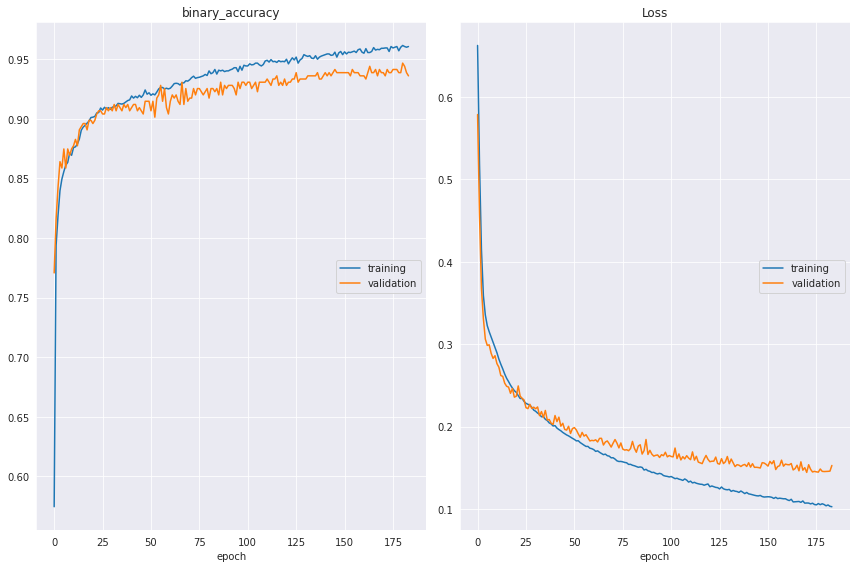

binary_accuracy
	training         	 (min:    0.575, max:    0.961, cur:    0.961)
	validation       	 (min:    0.771, max:    0.947, cur:    0.936)
Loss
	training         	 (min:    0.103, max:    0.662, cur:    0.103)
	validation       	 (min:    0.145, max:    0.579, cur:    0.153)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [ ]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.0min


In [ ]:
random_network['model'].get_config()

In [ ]:
random_network['model'].summary()

## Save and Plot Lambda-Model History

In [ ]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


In [ ]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [ ]:
loss_df.describe()

In [ ]:
val_loss_df.describe()

In [ ]:
metric_df.describe()

In [ ]:
val_metric_df.describe()

In [ ]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
